<a href="https://colab.research.google.com/github/AJH0625/NLP-study/blob/main/7%EC%9E%A5_RNN%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EB%AC%B8%EC%9E%A5_%EC%83%9D%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax 
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids=None, sample_size=100):
    word_ids=[start_id]

    x = start_id
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1,1)
      score = self.predict(x)
      p = softmax(score.flatten())

      sampled = np.random.choice(len(p), size=1, p=p)
      if(skip_ids is None) or (sampled not in skip_ids):
         x = sampled
         word_ids.append(int(x))

    return word_ids

## My life is~ 로 문장 만들기

In [26]:
import sys
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('ch06/Rnnlm.pkl')

start_word = 'my life is'
start_ids = [word_to_id[w] for w in start_word.split(' ')]

for x in start_ids[:-1]:
  x = np.array(x).reshape(1,1)
  model.predict(x)

skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

my life is just a free of instant branches are under pressure a taxpayers night.
 for example mr. times do n't expect research.
 so is a majority of nathan who had for an injunction unveil from the making two weeks after curb trusted cost fluor 's use of poland.
 some show tend to moving done even waste and aligned with the restriction for towers patients.
 the three years to show is made between years at the artist in trelleborg.
 it just began a company headed for his offers job of town when he is talking about your


In [3]:
import sys
sys.path.append('..')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [5]:
class Encoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V,D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)

    self.params = self.embed.params + self.lstm.params
    self.grads = self.embed.grads + self.lstm.grads
    self.hs = None

  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return hs[:, -1, :]

  def backward(self, dh):
    dhs = np.zeros_like(self.hs)
    dhs[:, -1, :] = dh

    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

In [8]:
class Decoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V,D)/100).astype('f')
    lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_w, affine_b)
    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, h):
    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    out = self.lstm.forward(out)
    score = self.affine.forward(out)
    return score

  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    dout = self.lstm.backward(dout)
    dout = self.embed.backward(dout)
    dh = self.lstm.dh
    return dh

  def generate(self, h, start_id, sample_size):
    sampled=[]
    sample_id = start_id
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array(sample_id).reshape((1,1))
      out = self.embed.forward(x)
    
    out = self.lstm.forward(out)
    score = self.affine.forward(out)

    sample_id = np.argmax(score.flatten())
    sampled.append(int(sample_id))

    return sampled

In [19]:
from base_model import *
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 13[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 15[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 18[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 19[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

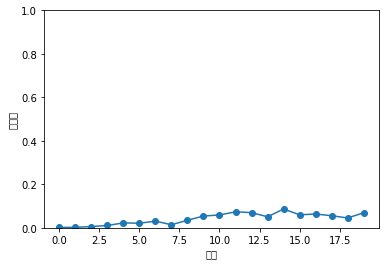

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq



# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 20
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

##개선된 seq2seq
1. Input Data의 반전:RNN의 Long Term Dependency를 해결하기 위하여 LSTM을 사용하였지만 Input Data의 의미있는 Data가 결국에는 가장 마지막에 들어와서 Forget Gate를 덜 거치는 것이 결과가 가장 좋을 것
> 모든 문장에서 주어와 동사는 가장 앞에서 나오므로 문장의 순서를 거꾸로 하여 Input Data로 사용했을 때 Model의 성능이 향상될 것!

In [28]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 20
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list2 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list2.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 13[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 15[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 17[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 18[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 19[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1001
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1001
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---

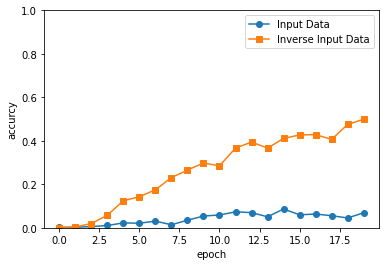

In [29]:
# 결과 시각화
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o',label='Input Data')
plt.plot(x, acc_list2, marker='s',label='Inverse Input Data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accurcy')
plt.ylim(0, 1.0)
plt.show()

2. Peeky: Decoder의 첫 번째 hidden layer로 들어가는 context vector 활용하기
> Context vector에는 decoder에 필요한 정보가 모두 담겨있으므로 context vector를 첫 번째 hidden layer의 input으로만 사용하지 않고 각각의 LSTM의 input과 affine 계층의 input으로 사용하기

In [30]:
from common.time_layers import *

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [31]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 20
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list3 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list3.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 9[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 10[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 11[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 18[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 19[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 21[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 22[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 102 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1023
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
--

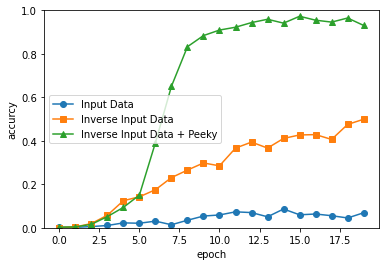

In [32]:
# 최종 결과
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o',label='Input Data')
plt.plot(x, acc_list2, marker='s',label='Inverse Input Data')
plt.plot(x, acc_list3, marker='^',label='Inverse Input Data + Peeky')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accurcy')
plt.ylim(0, 1.0)
plt.show()